# FEV vs. Alpha Analysis

For each SimCLR layer, this notebook plots **mean FEV** vs. **alpha** (where alpha is the slope of the log–log PCA variance spectrum).

- **Mean FEV** is taken from the regression: SimCLR features (reduced to N PCs) → Neural data (original dimensionality)

- For each layer, we select the **best FEV** (i.e., highest across PC counts)

In [1]:
from cortexlib.power_law import PowerLawAlphaEstimator
from cortexlib.utils import file as futils
from cortexlib.utils.logging import Logger
from cortexlib.utils.random import set_global_seed
from cortexlib.utils.plotting import simclr_colours
from adjustText import adjust_text
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd

logger = Logger()
set_global_seed()

In [2]:
MOUSE_ID = futils.get_mouse_id()
logger.info(f"This notebook is running for mouse {MOUSE_ID}")

14:44:47 | INFO     | ℹ️ This notebook is running for mouse m01_d2


In [3]:
fev_results = futils.read_json_file_as_dataframe('./prediction.json')
best_fev_per_layer = fev_results.loc[fev_results.groupby("layer")["mean_fev"].idxmax()]

best_fev_per_layer

,layer,n_pcs,test_r2,mean_fev
42,fc,300.0,0.024316,0.162557
3,layer1,50.0,0.034359,0.159821
9,layer2,NaN,0.039008,0.196576
18,layer3,NaN,0.046731,0.173795
29,layer4,20.0,0.025872,0.157266


In [4]:
simclr_data = futils.load_model_features(futils.Model.SIMCLR, MOUSE_ID)
simclr_feats = simclr_data['features']

14:44:47 | INFO     | ℹ️ Loading model features from /Users/callummessiter/workspace/msc-neuro/research-project/analysis/mouse_m01_d2/_model_features/simclr_features_mouse_m01_d2.pt


In [5]:
power_law_alpha_estimator = PowerLawAlphaEstimator()

alpha_results = []

logger.progress(f"Computing α for SimCLR features across layers")
for layer, feats in tqdm(simclr_feats.items(), desc="α for all SimCLR layers"):
    logger.progress(f"SimCLR {layer}")
    
    feats = feats if feats.dim() <= 2 else feats.view(feats.size(0), -1)
    alpha = power_law_alpha_estimator.compute_alpha(feats)

    alpha_results.append({
        'layer': layer,
        'alpha': alpha['alpha'],
        'alpha_no_pc1': alpha['alpha_no_pc1'],
    })

logger.success(f"Alphas computed")

14:44:47 | INFO     | ⏳ Computing α for SimCLR features across layers...


α for all SimCLR layers:   0%|          | 0/5 [00:00<?, ?it/s]

14:44:47 | INFO     | ⏳ SimCLR layer1...


14:44:56 | INFO     | ⏳ SimCLR layer2...
14:45:00 | INFO     | ⏳ SimCLR layer3...


14:45:03 | INFO     | ⏳ SimCLR layer4...


14:45:04 | INFO     | ⏳ SimCLR fc...


14:45:04 | SUCCESS  | ✅ Alphas computed!


In [6]:
futils.write_json_file(alpha_results, './dimensionality.json')

In [7]:
alpha_results_df = pd.DataFrame(alpha_results)
alpha_results_df

,layer,alpha,alpha_no_pc1
0,layer1,3.891484,4.270742
1,layer2,3.486880,3.872463
2,layer3,1.911123,1.916714
3,layer4,1.887081,1.894114
4,fc,1.701852,1.710708


In [8]:
merged_results = pd.merge(best_fev_per_layer, alpha_results_df, on='layer')
merged_results

,layer,n_pcs,test_r2,mean_fev,alpha,alpha_no_pc1
0,fc,300.0,0.024316,0.162557,1.701852,1.710708
1,layer1,50.0,0.034359,0.159821,3.891484,4.270742
2,layer2,NaN,0.039008,0.196576,3.486880,3.872463
3,layer3,NaN,0.046731,0.173795,1.911123,1.916714
4,layer4,20.0,0.025872,0.157266,1.887081,1.894114


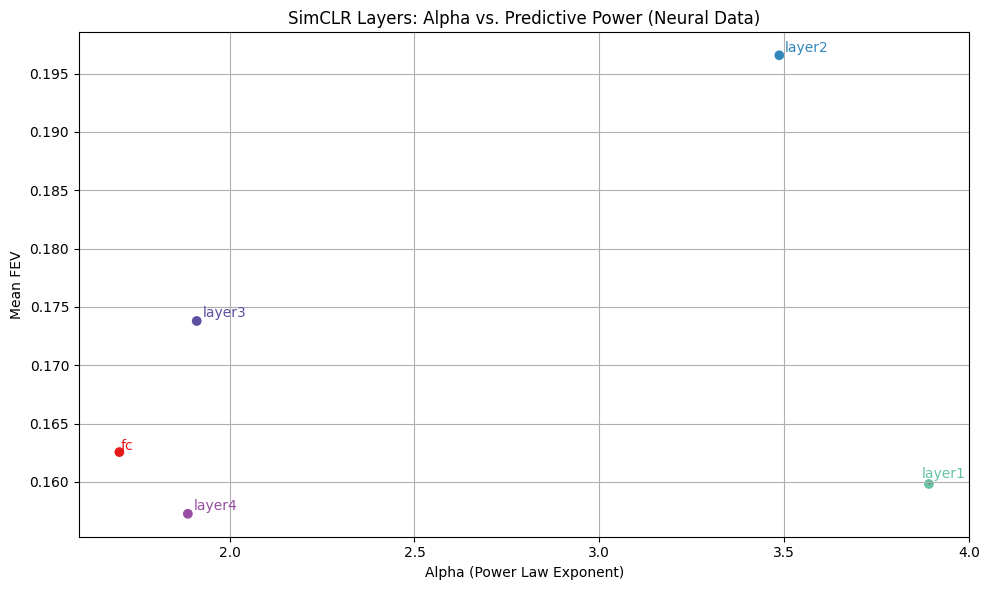

In [9]:
colours = merged_results['layer'].map(simclr_colours)

plt.figure(figsize=(10, 6))
plt.scatter(merged_results['alpha'], merged_results['mean_fev'], c=colours)

texts = []
for _, row in merged_results.iterrows():
    texts.append(
        plt.text(row['alpha'], row['mean_fev'], row['layer'],
                 color=simclr_colours[row['layer']], fontsize=10)
    )

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray'))

plt.xlabel('Alpha (Power Law Exponent)')
plt.ylabel('Mean FEV')
plt.title('SimCLR Layers: Alpha vs. Predictive Power (Neural Data)')
plt.grid(True)
plt.tight_layout()
plt.show()